In [1]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models

Using TensorFlow backend.


In [2]:
#특정 입력영상에 대한 각 레이어의 Activation Map 출력

model = load_model('./cats_and_dogs_small_2.h5')
print(model.summary())  






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
____________________________

In [4]:
img_path = './249.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)

img_tensor /= 255.

(150, 150, 3)
(1, 150, 150, 3)


In [0]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

# 층의 이름을 그래프 제목으로 사용
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)


In [7]:
print(layer_names)

['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'max_pooling2d_4']


In [0]:
images_per_row = 16

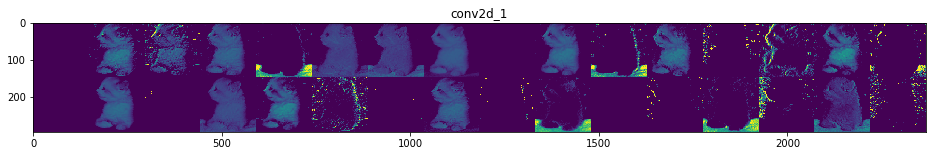

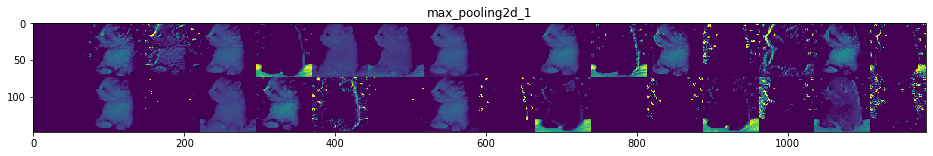

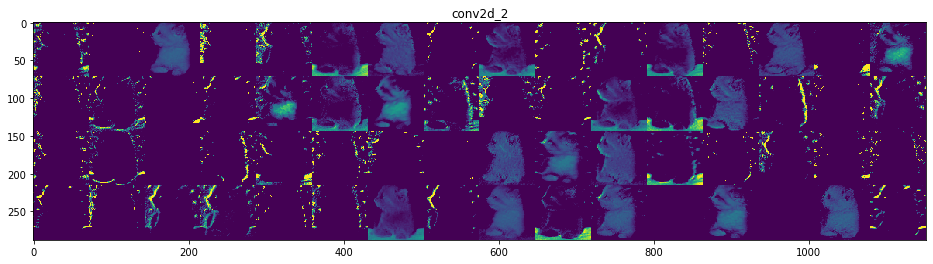

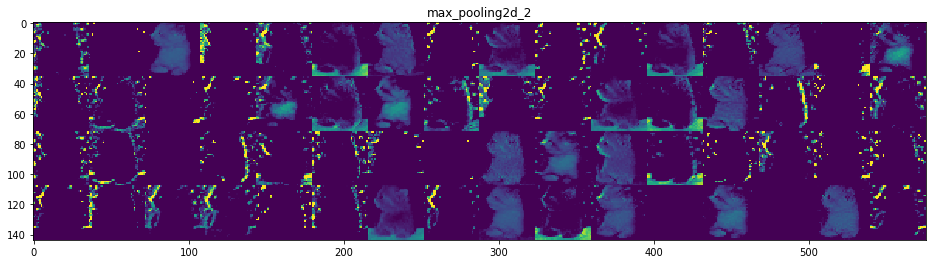

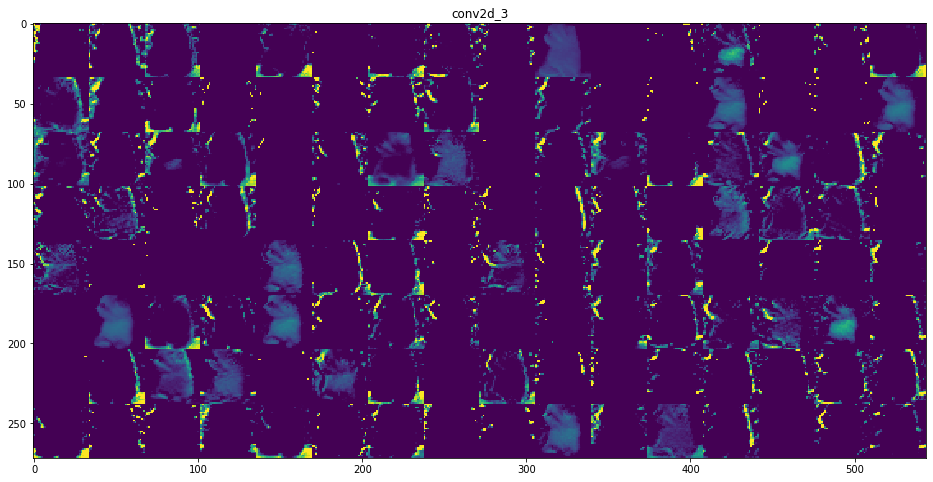

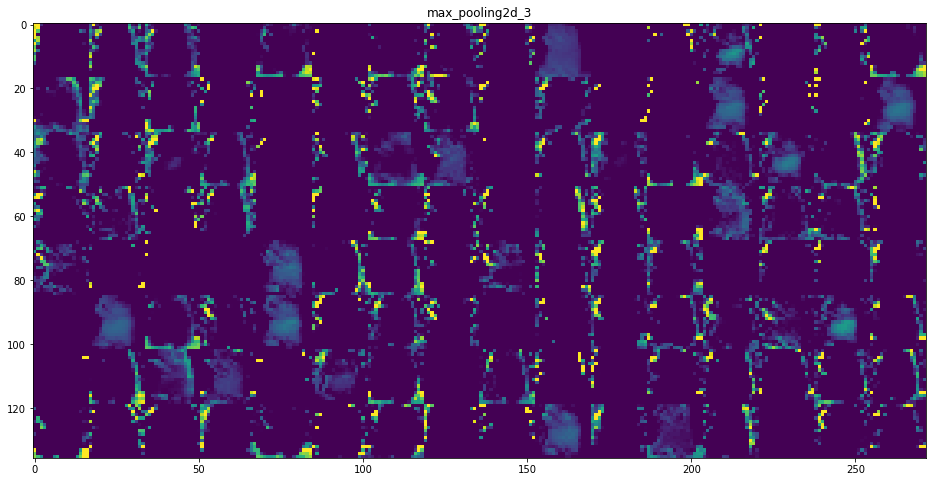

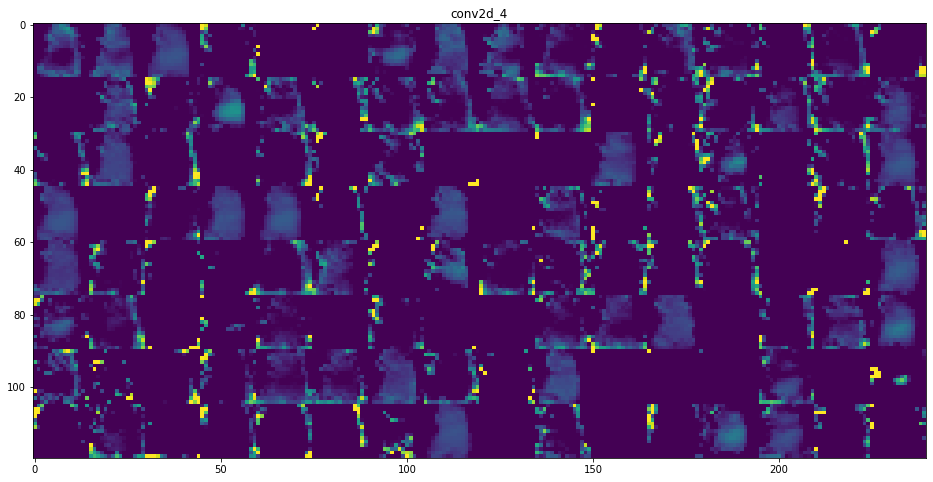

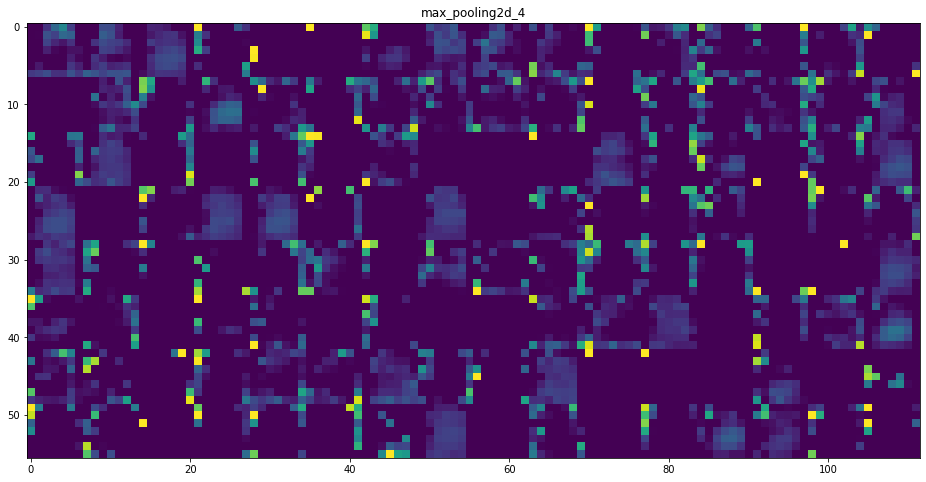

In [14]:

# 특성 맵
for layer_name, layer_activation in zip(layer_names, activations):

    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]


    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))


    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
#            channel_image -= channel_image.mean()
#            channel_image /= channel_image.std()
#            channel_image *= 64
#            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image


    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [15]:
#각 레이어의 필터 특성 출력

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [16]:
   
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
  
  
def generate_pattern(layer_name, filter_index, size=150):#imput에 대한 영상에 대해서 ross가 ... 이거 이해하셔야 해요 라고 말씀하심.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])#filter index 는 변수로 들어가고 특정 filter에 대한 indext를

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.#225의 중간값 128 랜덤영상을 입력으로 만들어주는 과정

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)
  
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  
        for j in range(8): 

            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)


            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img


    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
from keras.applications.vgg16 import preprocess_input, decode_predictions


K.clear_session()
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 6s 0us/step


In [0]:
img_path = './249.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)#영상을  array 형태로 
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [22]:

reds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02123394', 'Persian_cat', 0.43157163), ('n02328150', 'Angora', 0.28919467), ('n02112018', 'Pomeranian', 0.17284748)]


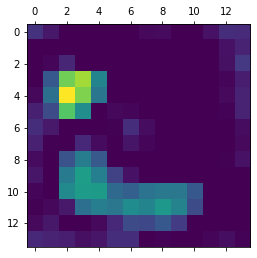

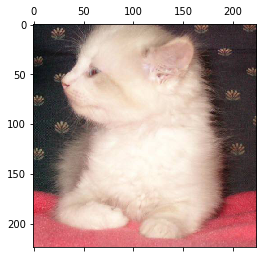

In [25]:
predict_output = model.output[:, np.argmax(preds[0])]#가장 높은 값을  predict output에 저장
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(predict_output, last_conv_layer.output)[0]#마지막 어레이를 가져오고
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])#맥스가 되는 피처를 가져오도록

pooled_grads_value, conv_layer_output_value = iterate([x])


for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)#마지막 axis가 피처에 해당하는 axis.
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)
plt.show()

plt.matshow(img)
plt.show()

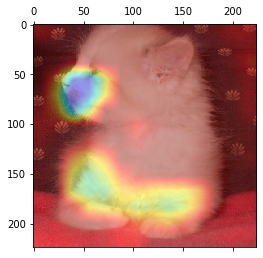

True

In [26]:
import cv2

background=image.img_to_array(img)
heatmap = cv2.resize(heatmap, (background.shape[1], background.shape[0]))
heatmap = np.uint8(255 * heatmap)#0~1사이의 값을 가지기 때문에 전체 range에 355를 성고0
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img =  np.uint8(heatmap * 0.4+ background*0.6)
plt.matshow(superimposed_img)
plt.show()

cv2.imwrite('elephant_cam.jpg', superimposed_img)